Necessary Libraries

In [1]:
import numpy as np
import regex as re
from tensorflow import keras
from sentence_transformers import SentenceTransformer
from transformers import T5ForConditionalGeneration, T5Tokenizer
import faiss
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

Loading and storing all the data files

In [2]:
file1 = open('Artificial_intelligence_wiki.txt','r')
file2 = open("Artificial_organ.txt","r")
file3 = open("Great_Pyramid_Giza_wiki.txt","r")
file4 = open("List_of_dates_predicted_for_apocalyptic_events_wiki.txt","r")
file5 = open("Psychological_effects_ of _Internet_use_Wikipedia.txt","r") 
Arti_Int_content = file1.read()
Arti_Organ_content = file2.read()
Great_Pyramid_content = file3.read()
List_of_dates_content = file4.read()
Psychological_effects_content = file5.read()
file1.close()
file2.close()
file3.close()
file4.close()
file5.close()

Concatenate all the Data to make a single text

In [3]:
whole_text = Arti_Int_content + Arti_Organ_content + Great_Pyramid_content + List_of_dates_content + Psychological_effects_content

Creating a funtion to clean the text removing square brackets, special Characters and new line specifiers

In [4]:
def preprocess_text(text):
    # text = re.sub(r'\s+','',text) # We dont need to remove spaces 
    text = re.sub(r'\[[0-9?a-z?A-Z]]','',text)
    return text.lower()

In [5]:
preprocessed_text = preprocess_text(whole_text)

Loading all-MiniLM-L6-v2 to convert document into vector Embeddings 

In [6]:
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

In [7]:
chunk_size = 512

Spliting the document into similar size of chunks

In [8]:
def chunk_text(text, chunk_size):
    return [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]

In [ ]:
# Before spliting into chunks we need to set sentence boundary
chunks = chunk_text(preprocessed_text, chunk_size)
chunks = [preprocess_text(chunk) for chunk in chunks]

Creating the embeddings for the chunks

In [10]:
chunk_embeddings = sentence_model.encode(chunks, show_progress_bar=True,convert_to_numpy=True)

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Build the IndexFlatL2 to store the chunks embedding into FAISS

In [11]:
index = faiss.IndexFlatL2(chunk_embeddings.shape[1])    
index.add(chunk_embeddings)

Input User Query, Preprocessed it to Clean and Encode it into embedding

In [12]:
query = input("Enter your query: ")
query = preprocess_text(query)
query_embedding = sentence_model.encode([query], convert_to_numpy=True)

In [13]:
print(query)

who made great pyramid of giza


Finding Top 5 Similar chunks with the query

In [14]:
k = 5 # No of top relevant chunk
cos_similarity = cosine_similarity(query_embedding, chunk_embeddings).flatten()
top_k_indices = cos_similarity.argsort()[-k:][::-1]
# distances, indices = index.search(query_embedding, k)

In [15]:
relevant_chunks = [chunks[i] for i in top_k_indices]
# relevant_chunks = [chunks[i] for i in indices[0]]


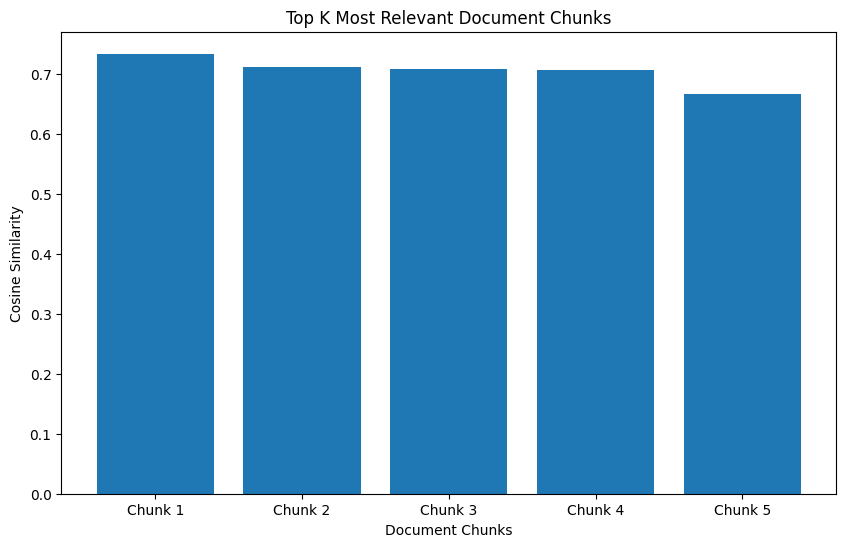

In [16]:
# Plot the cosine similarity scores
plt.figure(figsize=(10, 6))
plt.bar(range(k), [cos_similarity[i] for i in top_k_indices], tick_label=[f'Chunk {i+1}' for i in range(k)])
plt.xlabel('Document Chunks')
plt.ylabel('Cosine Similarity')
plt.title('Top K Most Relevant Document Chunks')
plt.show()

In [17]:
tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-small') # Load the T5 tokenizer
model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-small') # Load the T5 model  

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [18]:
input_text = " ".join(relevant_chunks)  # Combine the relevant chunks to form the input text for the model
input_ids = tokenizer.encode(input_text, return_tensors='pt') # Encode the input text
outputs = model.generate(input_ids, num_beams=5, early_stopping=True) # Generate the output using the model
answer = tokenizer.decode(outputs[0],skip_special_tokens=True) # Decode the generated output to get the answer

Token indices sequence length is longer than the specified maximum sequence length for this model (730 > 512). Running this sequence through the model will result in indexing errors


In [19]:
print(answer)

giza
